Explorar BBDD con Pyodbc

In [1]:
import pyodbc
import pandas as pd
import numpy as np

In [2]:
servidor = 'LUCKYDW01.LUCKY.LOCAL'  # Nombre del servidor SQL con el cual se hará la conexión
bddatos = 'BDXplora'  # Nombre de la base de datos SQL
usuario = 'alicorpmenor' # Nombre del usuario de SQL
clave = 'almenor2019#'  # Contraseña del usuario de SQL

try:
    conn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};\
                        SERVER='+servidor+';\
                        DATABASE='+bddatos+';\
                        UID='+usuario+';\
                        PWD='+clave)

except Exception as e:

    print("Ocurrió un error en la conexon: ", e)

Exploracion de BBDD con SQLAlchemy

In [3]:
from sqlalchemy.engine import URL, create_engine

connection_string = 'DRIVER={ODBC Driver 17 for SQL Server};\
                    SERVER='+servidor+';DATABASE='+bddatos+';UID='+usuario+';PWD='+clave
connection_url = URL.create("mssql+pyodbc", query={"odbc_connect": connection_string})
engine = create_engine(connection_url)

In [32]:
from sqlalchemy.orm import sessionmaker
with sessionmaker(bind=engine)() as session:
        #session=sessionmaker(bind=engine)()
        result=session.execute("SET NOCOUNT ON; EXEC [usp_DTS_alicorp_minorista_cliente_perfecto_precios] '01/05/2022','31/07/2022'")
        rows=result.fetchall()
        df=pd.DataFrame(rows,
                        columns=['FECHA_REGISTRO','COD_GESTOR','USUARIO','HORA_INICIO',\
                                'HORA_FIN','LATITUD_INICIO','LONGITUD_INICIO','LATITUD_FIN',\
                                'LONGITUD_FIN','TIPO_RELEVO','IMAGEN_VISITA','COD_PDV','PDV',\
                                'DIR_PDV','CANAL','ACTIVIDAD','REPORTE','COD_ELEMENTO','NOMBRE_ELEMENTO',\
                                'MOTIVO_NA','MOTIVO_NV','Precio Normal','Precio Promoción.','FOTO','Observación',\
                                'ID_REGISTRO_REPORTE']
                        )

In [33]:
if (isinstance(df["Precio Normal"], object)) | (isinstance(df["Precio Promoción."],object)):
    df["Precio Normal"]=df['Precio Normal'].str.replace(",",".").astype(float)
    df["Precio Promoción."]=df["Precio Promoción."].str.replace(",",".").astype(float)
else:
    pass

# Rellenar valores null a 0
df["Precio Normal"].fillna(0, inplace=True)
df["Precio Promoción."].fillna(0,inplace=True)

# Creacion de codigo unico para eliminar valores duplicados.
df["concat"]=df.FECHA_REGISTRO.dt.day.map(str)+\
            df.FECHA_REGISTRO.dt.month.map(str)+\
            df.FECHA_REGISTRO.dt.year.map(str)+\
            df.USUARIO+df.PDV+df.NOMBRE_ELEMENTO


df=df.drop_duplicates(subset=["concat"])

In [34]:
df=df.loc[(df["Precio Normal"]!=0) | (df["Precio Promoción."]!=0)]
df.reset_index(inplace=True)
for i in range(0,len(df.index)):
    if df["Precio Normal"][i]==0:
        val=df["Precio Promoción."][i]
        df["Precio Normal"][i]=val
    else:
        pass
df=df.drop(columns="index")
df=df.set_index("FECHA_REGISTRO")

C:\Users\ItaloFernandoVilaAre\AppData\Local\Temp\ipykernel_2200\421178445.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Precio Normal"][i]=val


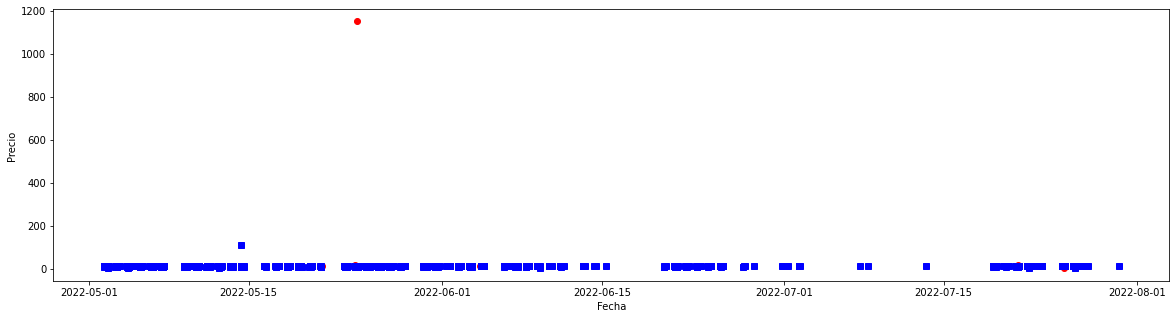

In [36]:
import matplotlib as mpl
import matplotlib.pyplot as plt

df_sku1=df[df.NOMBRE_ELEMENTO=="ACEITE COCINERO 1LT"]
df_sku2=df[df.NOMBRE_ELEMENTO=="ACEITE CIL  1LT"]
fig1=plt.figure(1)
plt.plot(df_sku1.index,df_sku1["Precio Normal"], 'ro', df_sku2.index, df_sku2["Precio Normal"], 'bs')
plt.xlabel("Fecha")
plt.ylabel("Precio")

fig1.set_size_inches(20,5)
plt.show()

In [ ]:
import statistics as sta
def MTC_file(file):
    #path=r'C:\Minorista\CP\precios\Base_test_clean.xlsx'
    df=file
    df["Mes"]=pd.to_datetime(df.index, format='%m').dt.month_name()

    start_list=[]
    df_result=pd.DataFrame(start_list)

    # Iteramos por Mes
    for i in df.Mes.unique():
        df1=df[df.Mes==i]
        sku_mes=df1["NOMBRE_ELEMENTO"].unique()
        sku=[]
        moda=[]
        media=[]
        dest=[]
        mounth=[]
        # Iteramos por SKU por mes
        for nombre_sku in sku_mes:
            mes=i
            df_sku=df1[df1["NOMBRE_ELEMENTO"]==nombre_sku]["Precio Normal"]
            df_sku=df_sku.fillna(0)
            sku.append(nombre_sku)
            moda.append(sta.mode(df_sku))
            media.append(sta.mean(df_sku))
            dest.append(sta.pstdev(df_sku))
            mounth.append(mes)
        # Apilamos dataframes por cada mes
        df_start=df_result
        data_last={'SKU':sku, 'Moda':moda, 'Media':media, 'Des.Est':dest, 'Mes':mounth}
        df_finish=pd.DataFrame(data_last)
        df_result=pd.concat([df_start,df_finish], axis=0)
    
    df_result.to_excel("MTC_Mensual_prueba.xlsx", index=False)
    return df_result


In [ ]:
def detect_ouliers_zscore(data):
    outliers=[]
    thres=2.5
    mean=np.mean(data)
    std=np.std(data)
    if std!=0:
        for i in data:
            z_score=(i-mean)/std
            if (np.abs(z_score)>thres):
                outliers.append(i)
    else:
        pass
    return outliers


In [ ]:
def replace_outliers(data,mtc_file):
    skus=data.NOMBRE_ELEMENTO.unique()
    for nombre_sku in skus:
        df_sku=data[data["NOMBRE_ELEMENTO"]==nombre_sku]
        sample_outliers=detect_ouliers_zscore(df_sku["Precio Normal"])
        if len(sample_outliers)!=0:
            for i in sample_outliers:
                moda=mtc_file[mtc_file.SKU==nombre_sku]["Moda"].iloc[0]
                df_sku.loc[df_sku["Precio Normal"]==i,"Precio Normal"]=moda
        else:
            pass
        data[data["NOMBRE_ELEMENTO"]==nombre_sku]=df_sku